In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import os
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
class_list = os.listdir(path)
class_list.remove('.DS_Store')
data_paths = [os.listdir(os.path.join(path, c)) for c in class_list]
sample_n = [len(c) for c in data_paths]
print(class_list)

['cat', 'butterfly', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']


In [289]:
import numpy as np
class Dataset:
    def __init__(self, BS, shuffle=True):
        self.BS = BS
        self.XIndex = list()
        self.y = list()
        for i, yi in enumerate(sample_n):
            for xi in range(yi):
                self.y.append(i)
                self.XIndex.append(xi)
        self.XIndex = np.array(self.XIndex)
        self.y = np.array(self.y)
        self.l = len(self.y)
        if shuffle:
            randl = list(range(self.l))
            np.random.shuffle(randl)
            self.XIndex = self.XIndex[randl]
            self.y = self.y[randl]
    def __len__(self):
        return int(np.ceil(self.l/self.BS))
    def __getitem__(self, key):
        start = key * self.BS
        assert start < self.l
        stop = start + self.BS
        if stop > self.l and start < self.l:
            stop = self.l
        return self.XIndex[start:stop], self.y[start:stop]
    def __iter__(self):
        for b in range(len(self)):
            start = b*self.BS
            X, y = self.XIndex[start:start+self.BS], self.y[start:start+self.BS]
            X_path = list()
            for xs, ys in zip(X, y):
                X_path.append(os.path.join(path,class_list[ys],data_paths[ys][xs]))
            X_path = np.array(X_path)
            X_Images = self.toMem(X_path)
            yield X_Images, y
    def toMem(self, X_path):
        from PIL import Image
        X_images = list()
        for img_path in X_path:
            im = Image.open(img_path)
            X_images.append(im)
        return X_images
        
'''
getdata = Dataset(BS=150)
for x_b, y_b in getdata:
    print(type(x_b[0]))
    # print(x_b, y_b, x_b.shape, y_b.shape)
'''

'\ngetdata = Dataset(BS=150)\nfor x_b, y_b in getdata:\n    print(type(x_b[0]))\n    # print(x_b, y_b, x_b.shape, y_b.shape)\n'

In [325]:
import torch
# torch.manual_seed(17)
from torchvision import datasets, transforms
BS = 150
IM_HEIGHT = 425
IM_WIDTH = 600
transform = transforms.Compose([transforms.Resize([IM_HEIGHT, IM_WIDTH]), transforms.ToTensor()])
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
dataset = datasets.ImageFolder(path, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)*0.3)+1])
dataloader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)

torch.Size([150, 3, 425, 600]) torch.Size([3, 425, 600])


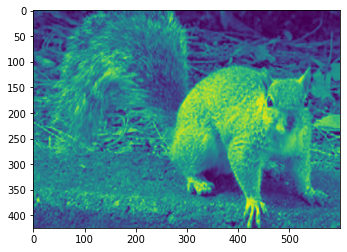

tensor([[0.3294, 0.3373, 0.3490,  ..., 0.1490, 0.1490, 0.1490],
        [0.3294, 0.3373, 0.3490,  ..., 0.1490, 0.1490, 0.1490],
        [0.3333, 0.3373, 0.3451,  ..., 0.1451, 0.1412, 0.1412],
        ...,
        [0.4000, 0.3804, 0.3373,  ..., 0.3725, 0.3882, 0.4000],
        [0.4000, 0.3765, 0.3255,  ..., 0.3490, 0.3882, 0.4118],
        [0.4000, 0.3765, 0.3255,  ..., 0.3451, 0.3882, 0.4118]])
tensor(0.0039)
tensor(1.)


In [326]:
import matplotlib.pyplot as plt
i, l = next(iter(dataloader))
print(i.shape, i[0].shape)
plt.imshow(i[0][2])
plt.show()
print(i[0][0])
print(torch.min(i[0][0]))
print(torch.max(i[0][0]))

In [328]:
import torch.nn as nn
import torch.nn.functional as F
class someNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(IM_HEIGHT*IM_WIDTH*3, 10)
        nn.init.normal_(self.l1.weight, mean=0, std=0.1)
    def forward(self, x):
        x = self.l1(x)
        x = F.log_softmax(x)
        return x

model = someNet()

In [ ]:
N_ITER = 10
def train():
    for i in range(N_ITER):
        for x_b, y_b in dataloader:
            pred = model.forward(x_b)

